- $\textbf{Author}$: Patrick Mthisi
- $\textbf{Contact details}$: patrickmthisi@hotmail.com

# Give me credit project description and results:

The data used in this project can be found on Kaggle: https://www.kaggle.com/c/GiveMeSomeCredit/data

In this project, we used Fastai's TabularLearner to build a deep NN for credit classification. As the dataset is highly imbalanced, we employed two techniques to take into account this fact during modelling, and they are as follows:

- We employed oversampling for the minority class using simple random oversampling
- In addition, we also employed cost-sensitive learning into our TabularLearner model.

Due to the significant missingness in the data, we utilised KNN imputation instead of simpler techniques like mean or median imputation to maintain variability in the dataset.

Using FastAI's TabularLearner for this classification task—characterized by significant class imbalance—posed challenges compared to more established models like XGBoost or LightGBM, which are often easier to tune and interpret. However, the model performed well on the independent test set, achieving a recall of 0.62, ROC AUC of 0.85, PR AUC of 0.36, and Matthew’s correlation coefficient of 0.36. We selected an optimal classification threshold of 0.39 using Youden’s statistic to balance sensitivity and specificity.  

# Import libraries

In [1]:
%config InlineBackend.figure_format = 'retina'
import zipfile
import pandas as pd
import numpy as np

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_curve
from sklearn.impute import KNNImputer      
from sklearn.pipeline import make_pipeline

from fastai.metrics import accuracy, Recall, Precision, Metric
from fastai.tabular.all import *
from fastai.tabular.all import Categorize
from fastai.losses import CrossEntropyLossFlat

import torch
from torch import tensor, float32

from imblearn.over_sampling import RandomOverSampler

import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(context='notebook', 
              style='whitegrid',
              palette='colorblind', 
              color_codes=True, 
              rc={'figure.figsize': [10, 6]})

# User-defined functions:

In [2]:
def extract_zip_files(zip_file_path, extract_to_dir):
    zip_file_path = zip_file_path
    extract_to_dir = extract_to_dir
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_dir)
        print(f"Contents of {zip_file_path} extracted successfully to {extract_to_dir}.")
    except FileNotFoundError:
        print(f"Error: The file {zip_file_path} does not exist.")
    except zipfile.BadZipFile:
        print(f"Error: The file {zip_file_path} is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        
class AveragePrecision(Metric):
    def __init__(self): self.preds, self.targets = [], []
    
    def reset(self):
        self.preds, self.targets = [], []
    
    def accumulate(self, learn):
        preds = learn.pred.softmax(dim=1)[:, 1].detach().cpu()
        targs = learn.y.detach().cpu()
        self.preds.append(preds)
        self.targets.append(targs)
    
    @property
    def value(self):
        preds = torch.cat(self.preds).numpy()
        targets = torch.cat(self.targets).numpy()
        return average_precision_score(targets, preds)

# Load data:

In [3]:
zip_file_path = 'GiveMeSomeCredit.zip'
extract_to_dir = './Data'
extract_zip_files(zip_file_path, extract_to_dir)

Contents of GiveMeSomeCredit.zip extracted successfully to ./Data.


In [4]:
# Load the dataset
df = pd.read_csv("./Data/cs-training.csv", na_values=np.nan).drop(columns=["Unnamed: 0"])
print(df["SeriousDlqin2yrs"].value_counts(normalize=True) * 100)

SeriousDlqin2yrs
0    93.316
1     6.684
Name: proportion, dtype: float64


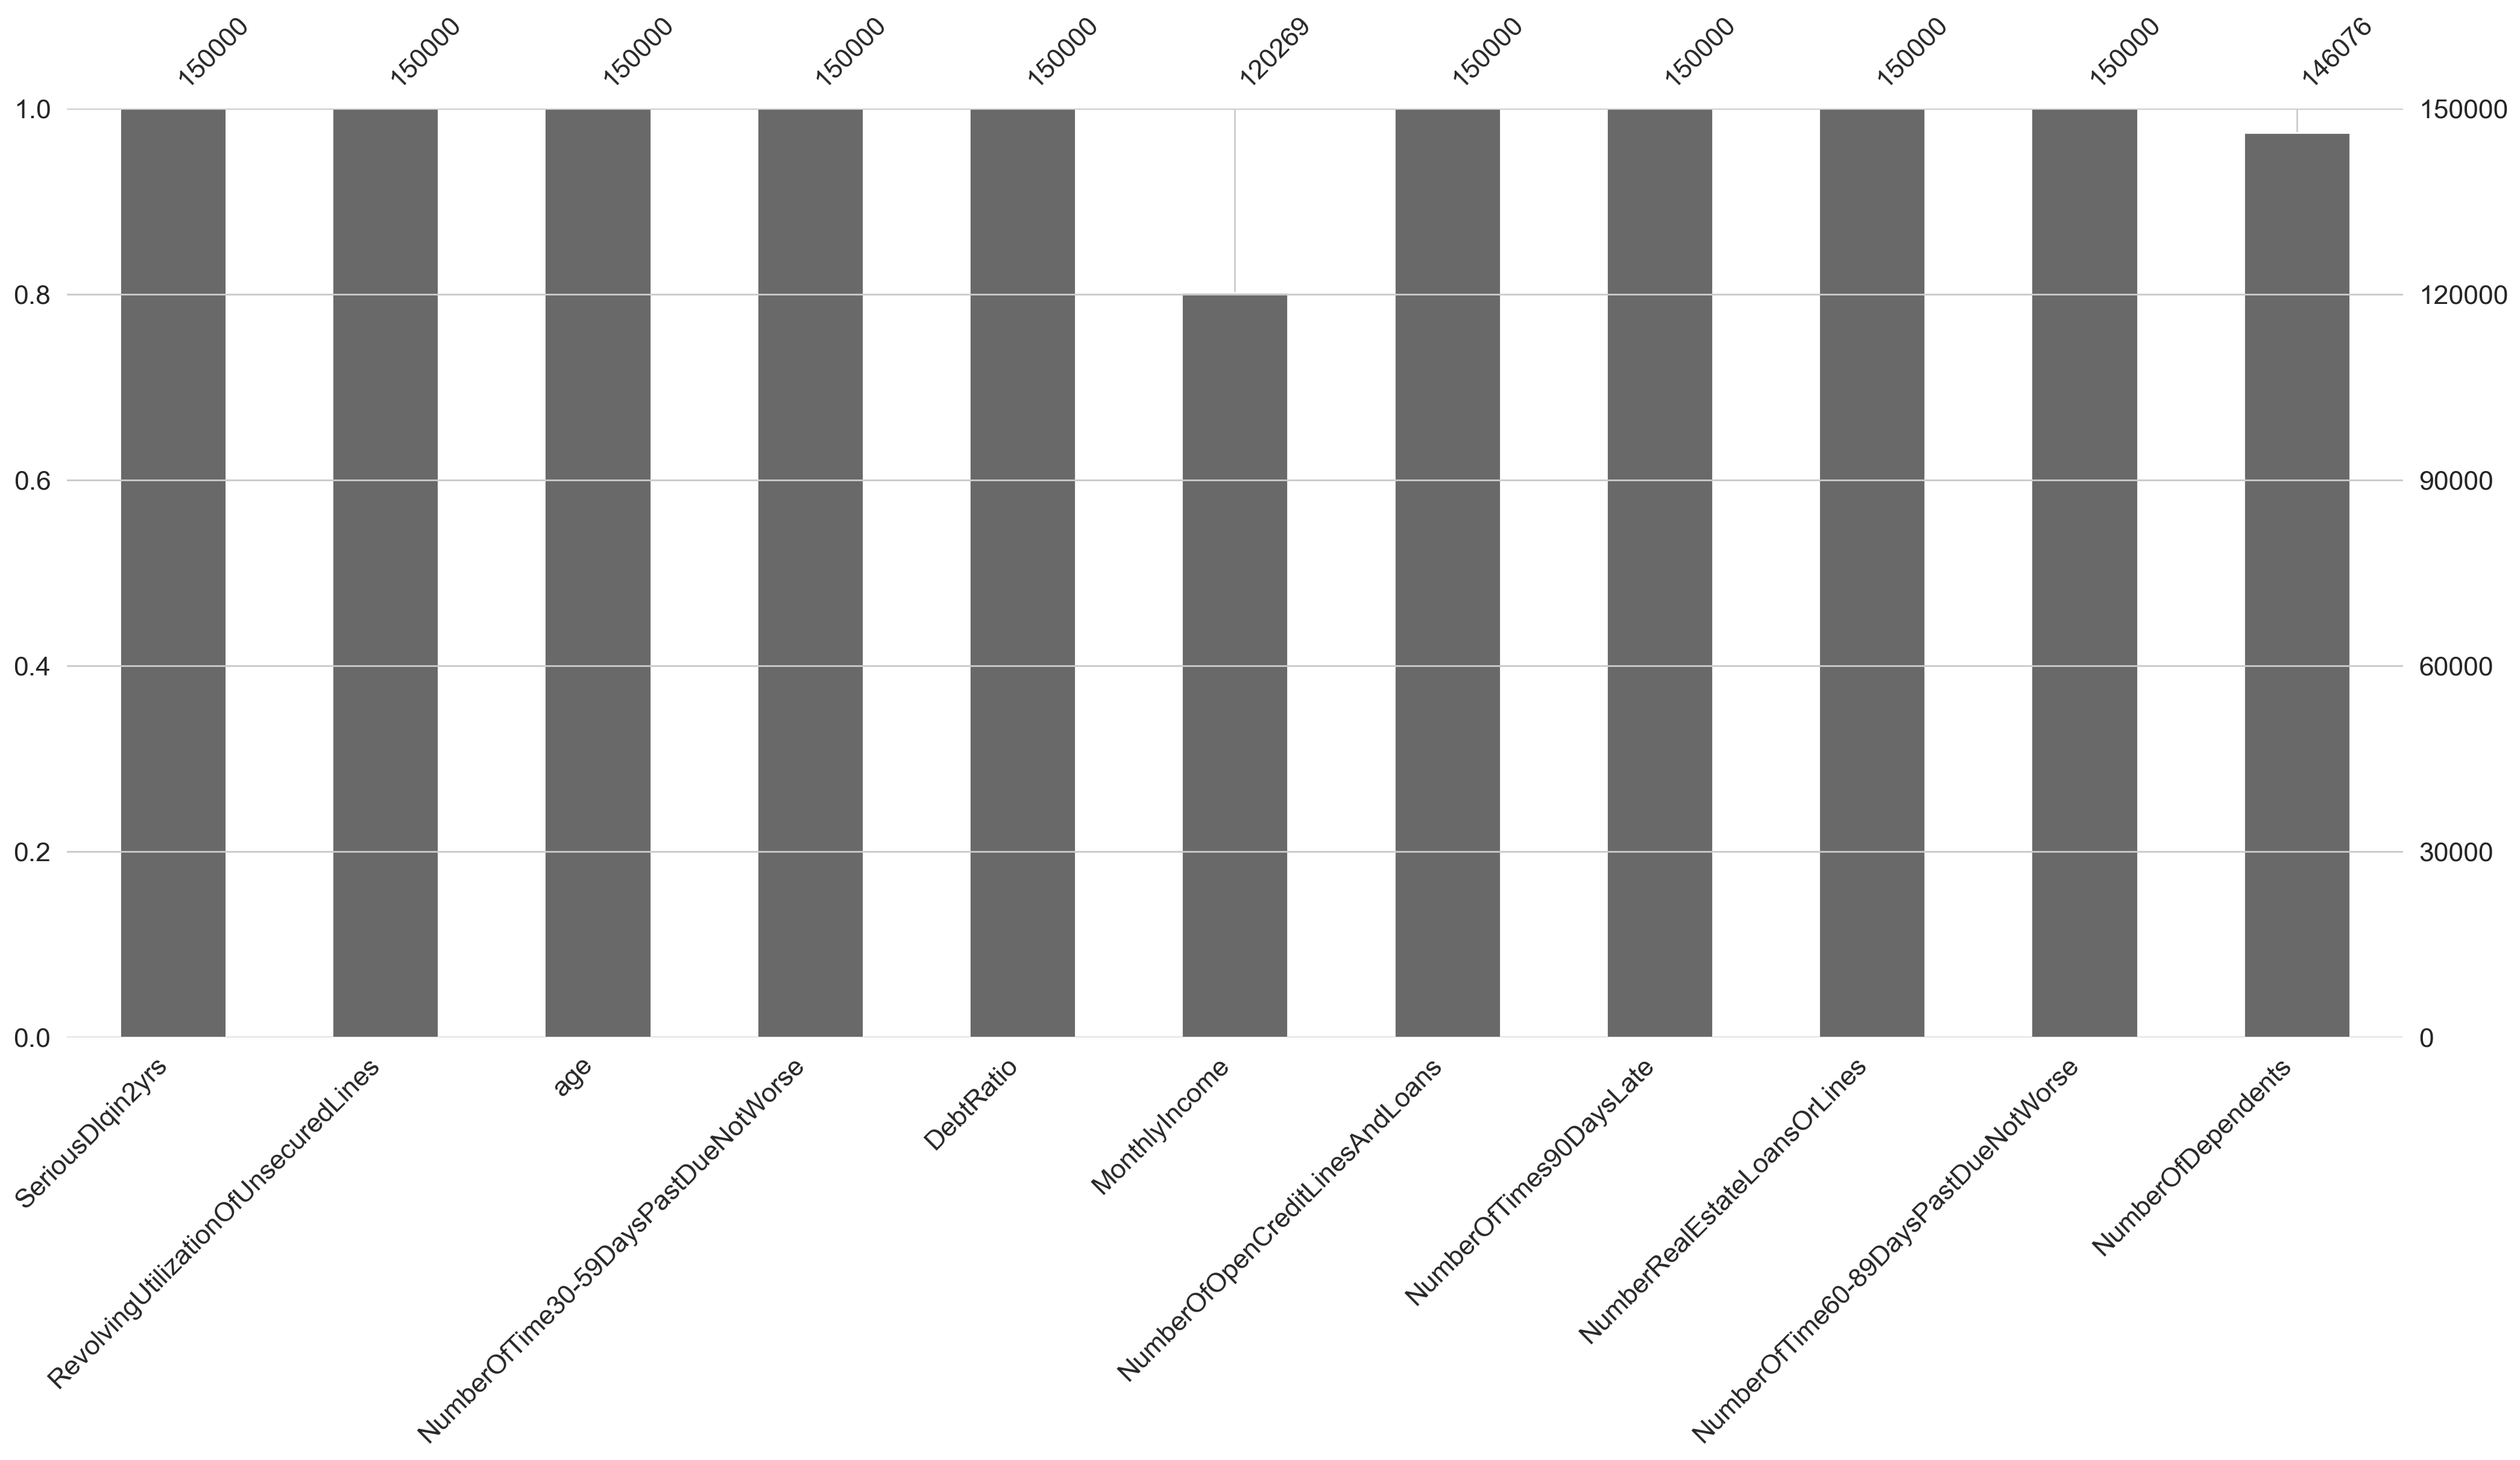

In [8]:
msno.bar(df);

# Model development:

In [7]:
TARGET = "SeriousDlqin2yrs"
N_FOLDS = 5
RANDOM_STATE = 42 
BATCH_SIZE = 64

X = df.copy()
y = X.pop(TARGET)

variable_names = df.columns.to_list()

num_features = df.select_dtypes(include="number").columns.to_list()
cat_features = df.select_dtypes(include="object").columns.to_list()
num_features.remove(TARGET)

splitter = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
train_idx, valid_idx = next(splitter.split(X, y))
X_train, y_train, X_valid, y_valid = X.iloc[train_idx], y.iloc[train_idx], X.iloc[valid_idx], y.iloc[valid_idx]

preprocessing = make_pipeline(
    KNNImputer(), 
    PowerTransformer()
)

X_train = preprocessing.fit_transform(X_train)
X_valid = preprocessing.transform(X_valid)


sampler = RandomOverSampler(sampling_strategy=0.1, random_state=RANDOM_STATE)
X_train_bal, y_train_bal = sampler.fit_resample(X_train, y_train)

df_train_bal = pd.DataFrame(X_train_bal, columns=X.columns)
df_valid = pd.DataFrame(X_valid, columns=X.columns)

df_train_bal[TARGET] = y_train_bal.astype(int)
df_valid[TARGET] = y_valid.values.astype(int)

df_final = pd.concat([df_train_bal, df_valid], axis=0).reset_index(drop=True)
split_idxs = (list(range(len(df_train_bal))), list(range(len(df_train_bal), len(df_final))))



tabular_df = TabularPandas(
    df=df_final,
    procs=[Categorify, FillMissing, Normalize],
    cat_names=cat_features,
    cont_names=num_features,
    y_names=TARGET,
    y_block=CategoryBlock(),
    splits=split_idxs
)

data_loader = tabular_df.dataloaders(bs=BATCH_SIZE, drop_last=True)

pos_weight = len(y_train_bal[y_train_bal==0]) / len(y_train_bal[y_train_bal==1])
loss_func = CrossEntropyLossFlat(weight=torch.tensor([1.0, pos_weight]))

learn = tabular_learner(
    data_loader,
    layers=[800, 400, 200],
    config={"ps": [0.75, 0.5, 0.2]},
    metrics=[accuracy, Recall(), Precision(), AveragePrecision()], # dropout layers
    cbs=[
        EarlyStoppingCallback(monitor="accuracy", patience=10),
        SaveModelCallback(monitor="accuracy", fname="best_model")
    ],
    loss_func=loss_func
)

learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=10, out_features=800, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.75, inplace=False)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=800, out_features=400, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=400, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.2, inplace=False)
    )
    (3): LinBnDrop(
      (0): Linear(

SuggestedLRs(valley=0.007585775572806597)

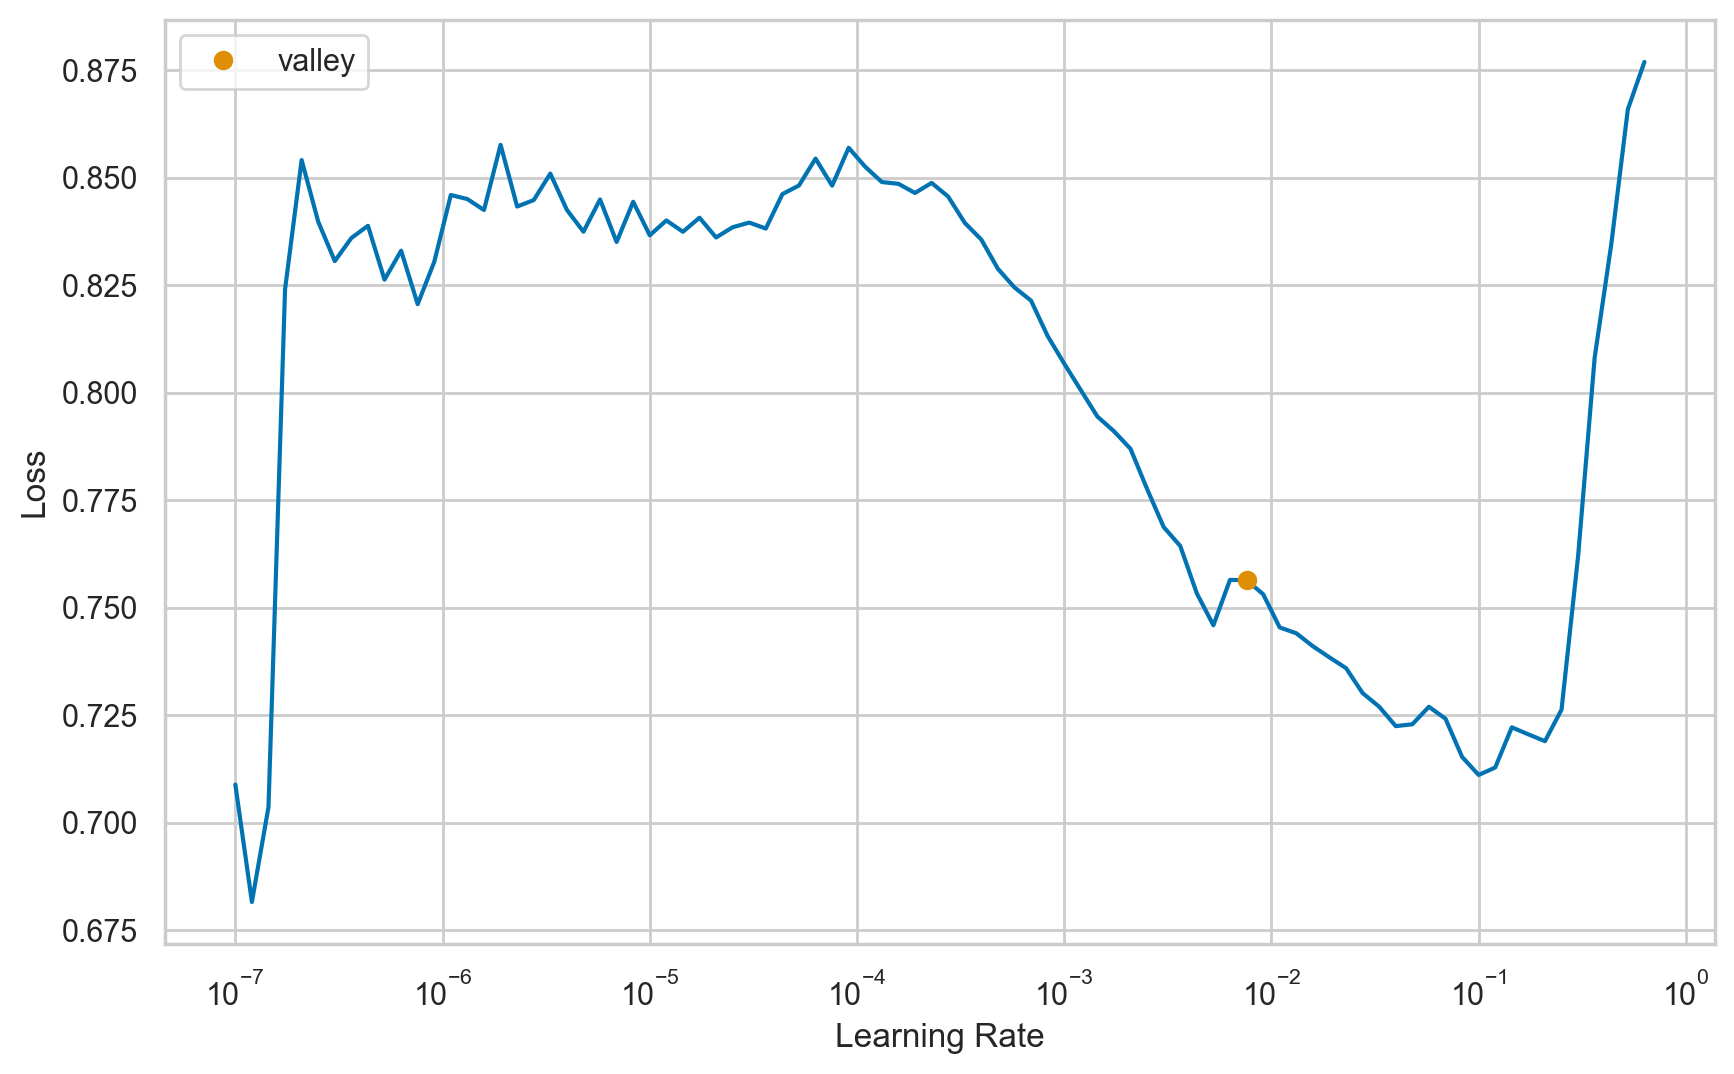

In [8]:
learn.lr_find()

In [16]:
learn.fit(n_epoch=100, lr=7e-3, wd=0.25)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,average_precision,time
0,0.500722,0.482371,0.811067,0.697906,0.216651,0.349750,00:20
1,0.492105,0.474769,0.837767,0.680459,0.244142,0.359543,00:19
2,0.503174,0.482287,0.750267,0.782154,0.181934,0.349850,00:19
3,0.520104,0.484839,0.829633,0.695912,0.236731,0.362113,00:19
4,0.471252,0.479086,0.871533,0.617149,0.286309,0.362680,00:20
5,0.518702,0.473201,0.849467,0.646560,0.254114,0.363005,00:21
6,0.490360,0.491188,0.855367,0.637587,0.261501,0.345001,00:24
7,0.495235,0.469898,0.823000,0.703390,0.230330,0.358918,00:28
8,0.512463,0.482574,0.747433,0.800598,0.182853,0.360092,00:28
9,0.490979,0.495723,0.818700,0.670987,0.219755,0.346054,00:25


Better model found at epoch 0 with accuracy value: 0.8110666871070862.
Better model found at epoch 1 with accuracy value: 0.8377666473388672.
Better model found at epoch 4 with accuracy value: 0.8715333342552185.
No improvement since epoch 4: early stopping


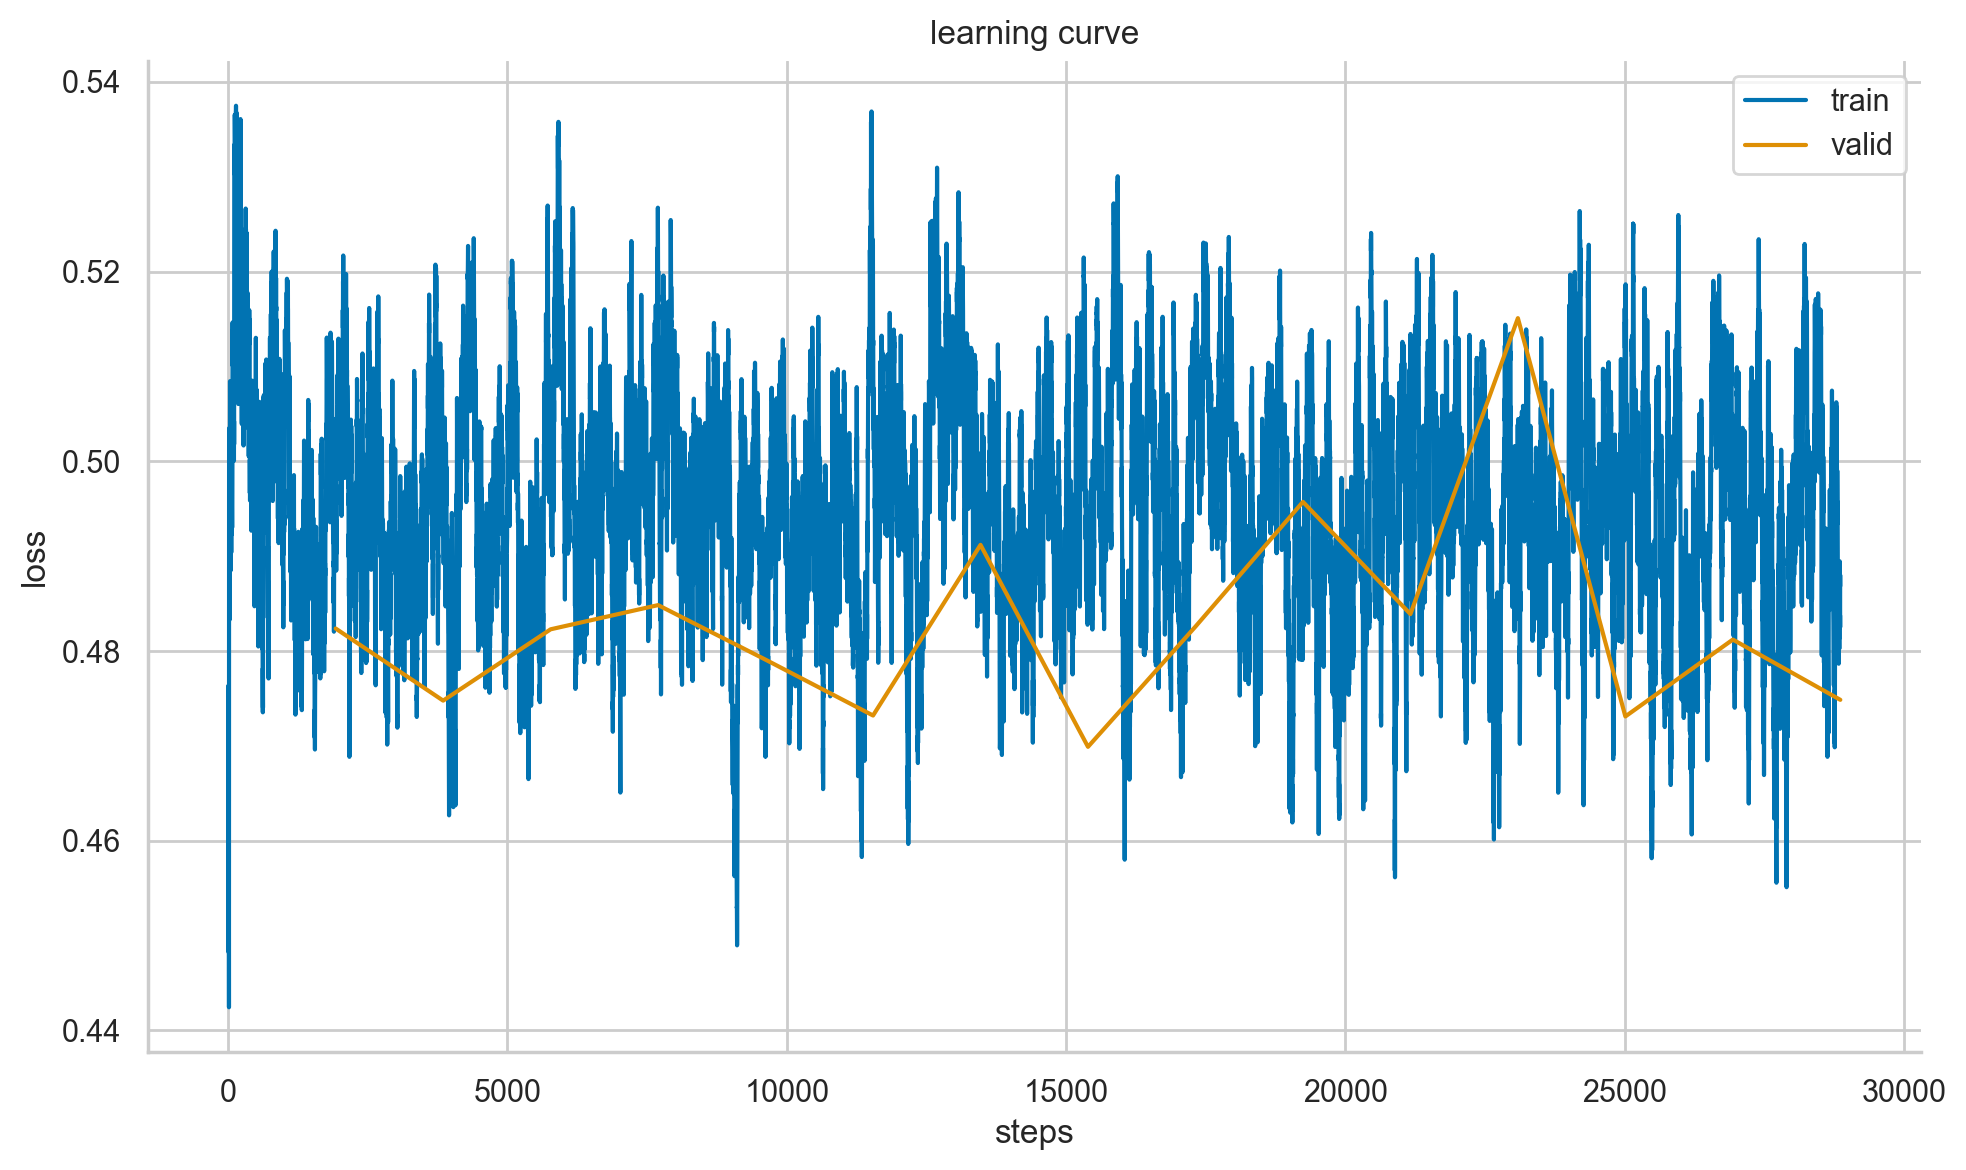

In [17]:
learn.recorder.plot_loss()
plt.tight_layout()
sns.despine()

# Model evaluation:

In [18]:
valid_data_loader = learn.dls.test_dl(df_final.loc[list(split_idxs[1])])
learn.validate(dl=valid_data_loader)

Better model found at epoch 0 with accuracy value: 0.617148554336989.


(#5) [0.47908613085746765,0.8715333342552185,0.617148554336989,0.286308973172988,0.36267999983338206]

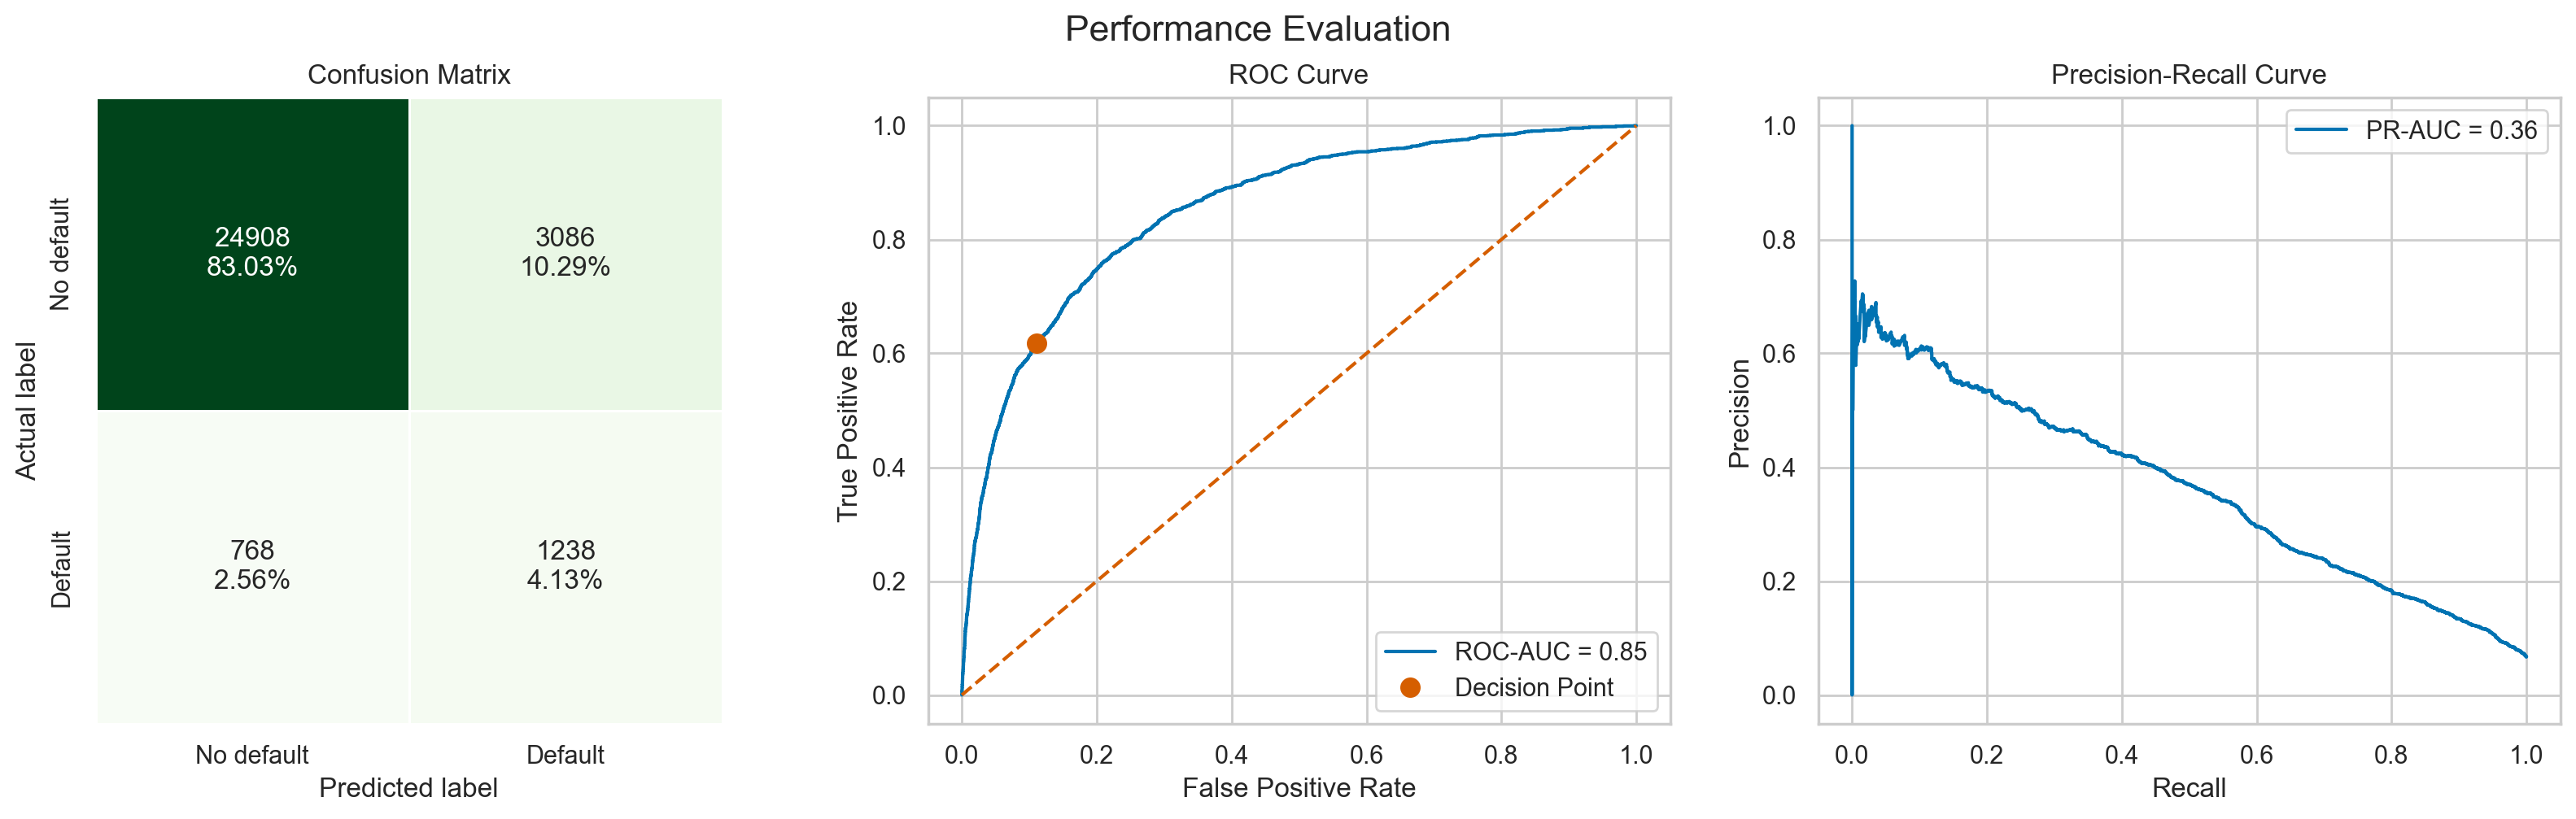

In [19]:
LABELS = ["No default", "Default"]
perf = performance_evaluation_report_fastai(
    learn, valid_data_loader, labels=LABELS, show_plot=True, show_pr_curve=True
)

In [20]:
preds, targs = learn.get_preds()
fpr, tpr, thresholds = roc_curve(targs, preds[:, 1])
optimal_idx = np.argmax(tpr - fpr)  # Youden's J statistic
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold based on Youden's statistic: {optimal_threshold:.4f}")

Optimal threshold based on Youden's statistic: 0.3891


In [21]:
print(perf)

{'accuracy': 0.8715333333333334, 'precision': 0.286308973172988, 'recall': 0.617148554336989, 'specificity': 0.8897620918768308, 'f1_score': 0.3911532385466035, 'cohens_kappa': 0.32994155412018367, 'matthews_corr_coeff': 0.3605145771231965, 'roc_auc': 0.8537100084329423, 'pr_auc': 0.3621221050418805, 'average_precision': 0.36267999983338206}
